In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from helpers import load_dataset_paths, process_file, compute_average_signal
import pywt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from CNN_classifier import Multichannel_1DCNN

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Loading preprocessed files

In [2]:
all_paths = load_dataset_paths(devices=["PRIMA", "MP20"])

print(all_paths)

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

mp20_files_BC_only = all_paths["MP20"]["BC_Only"]
mp20_files_RGC_only = all_paths["MP20"]["RGC_Only"]
mp20_files_BC_and_RGC = all_paths["MP20"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")

print(f"MP20 BC_Only files: {len(mp20_files_BC_only)}")
print(f"MP20 RGC_Only files: {len(mp20_files_RGC_only)}")
print(f"MP20 BC_and_RGC files: {len(mp20_files_BC_and_RGC)}")

# exclude SNR_summary_BC_and_RGC.csv from the list
prima_files_BC_and_RGC = [f for f in prima_files_BC_and_RGC if not f.endswith("SNR_summary_BC_and_RGC.csv")]
prima_files_RGC_only = [f for f in prima_files_RGC_only if not f.endswith("SNR_summary_RGC_Only.csv")]
prima_files_BC_only = [f for f in prima_files_BC_only if not f.endswith("SNR_summary_BC_Only.csv")]
mp20_files_BC_and_RGC = [f for f in mp20_files_BC_and_RGC if not f.endswith("SNR_summary_BC_and_RGC.csv")]
mp20_files_RGC_only = [f for f in mp20_files_RGC_only if not f.endswith("SNR_summary_RGC_Only.csv")]
mp20_files_BC_only = [f for f in mp20_files_BC_only if not f.endswith("SNR_summary_BC_Only.csv")]

{'PRIMA': {'BC_Only': ['Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_9_10ms_0.60mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_13_0_5ms_1.11mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_11_5ms_0.63mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_11_1ms_1.02mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_9_0_5ms_2.22mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_11_10ms_0.45mWmm2_2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_9_5ms_0.63mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_5_3ms_0.84mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_9_1ms_1.02mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_5_3ms_0.60mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_6_5ms_0.42mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_10_10ms_0.60mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_13_3ms_0.68mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/RCS_PRIMA100_1_1ms_0.80mWmm2.csv', 'Prepr

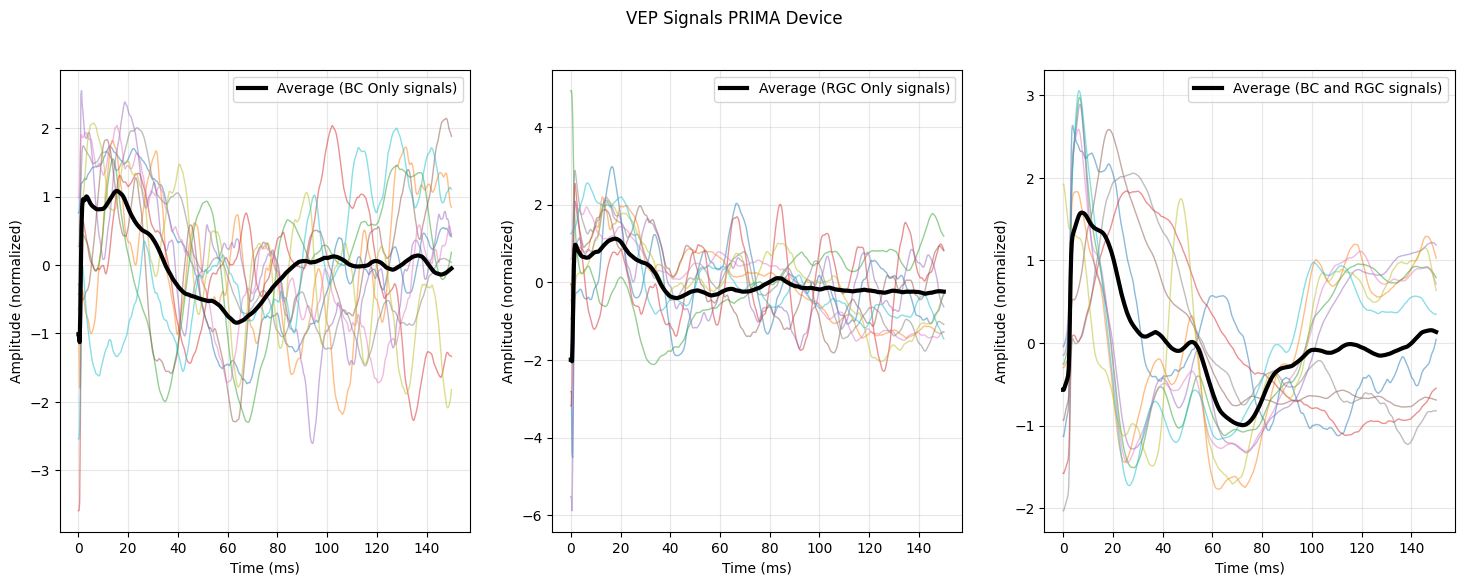

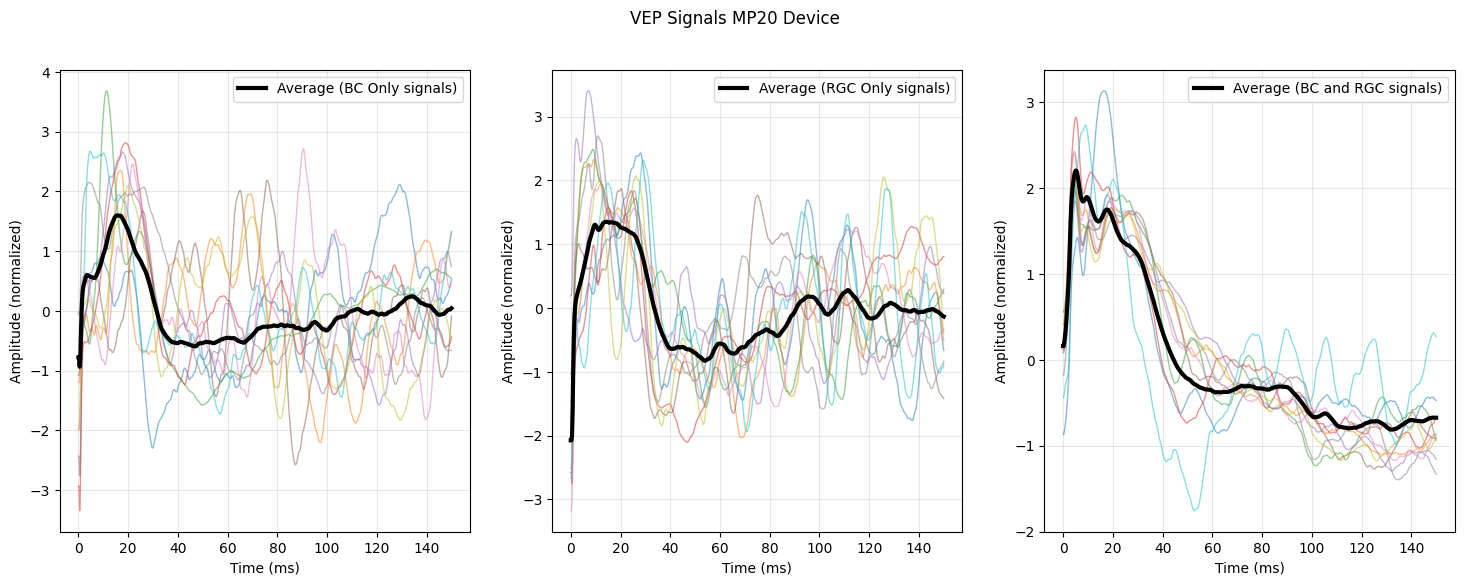

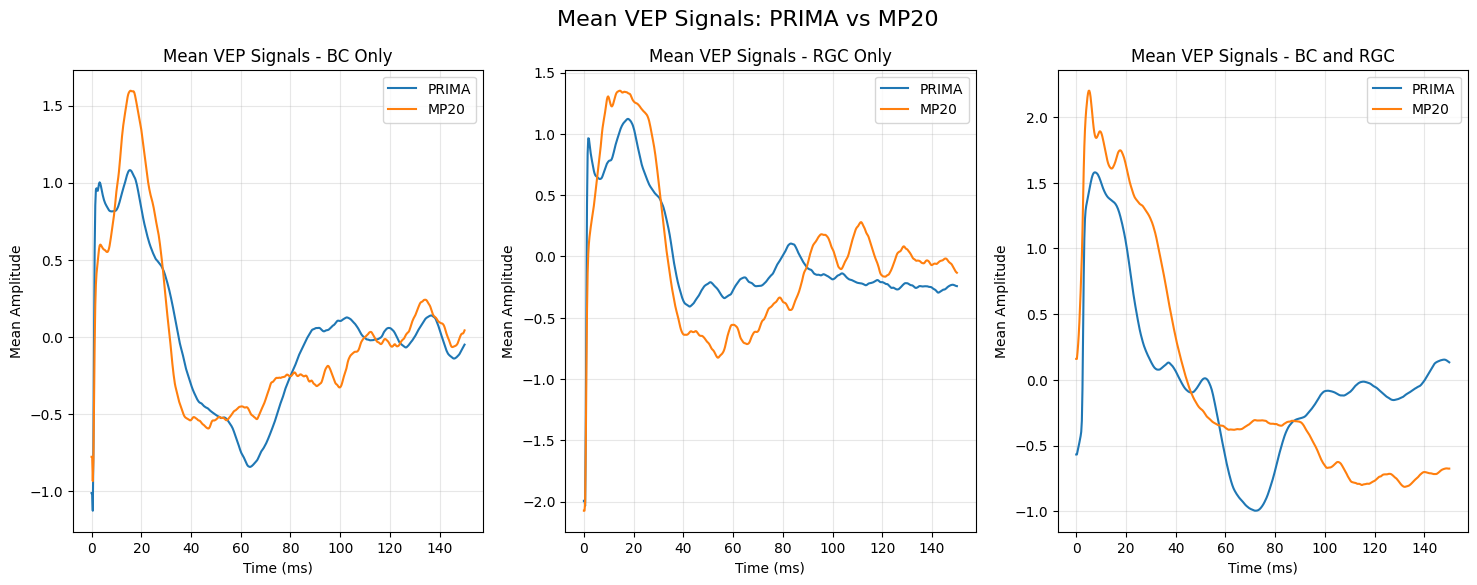

In [3]:
TMAX = 150

avg_BC_t, avg_BC_sig = compute_average_signal(prima_files_BC_only,  t_max=TMAX)
avg_RGC_t, avg_RGC_sig = compute_average_signal(prima_files_RGC_only, t_max=TMAX)
avg_BC_RGC_t, avg_BC_RGC_sig = compute_average_signal(prima_files_BC_and_RGC, t_max=TMAX)

# --- Choose 3 example files per category ---
example_files_BC = prima_files_BC_only[:10]
example_files_RGC = prima_files_RGC_only[:10]
example_files_BC_and_RGC = prima_files_BC_and_RGC[:10]

categories = [
    (example_files_BC, "BC Only", avg_BC_t, avg_BC_sig),
    (example_files_RGC, "RGC Only", avg_RGC_t, avg_RGC_sig),
    (example_files_BC_and_RGC, "BC and RGC", avg_BC_RGC_t, avg_BC_RGC_sig)
]

# --- Plot ---
plt.figure(figsize=(18, 6))
plt.suptitle("VEP Signals PRIMA Device")
for i, (file_list, title, avg_t, avg_sig) in enumerate(categories, 1):
    plt.subplot(1, 3, i)

    # Plot some example signals
    for file in file_list:
        time, signal = process_file(file, t_max=TMAX, normalize=True)
        plt.plot(time, signal, alpha=0.5, lw=1)

    # Plot the class-wide average in black
    plt.plot(avg_t, avg_sig, color="k", lw=3, label=f"Average ({title} signals)")

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
plt.show()

# -- Plot MP20 averages ---
avg_BC_t_mp20, avg_BC_sig_mp20 = compute_average_signal(mp20_files_BC_only,  t_max=TMAX)
avg_RGC_t_mp20, avg_RGC_sig_mp20 = compute_average_signal(mp20_files_RGC_only, t_max=TMAX)
avg_BC_RGC_t_mp20, avg_BC_RGC_sig_mp20 = compute_average_signal(mp20_files_BC_and_RGC, t_max=TMAX)

example_files_BC_mp20 = mp20_files_BC_only[:10]
example_files_RGC_mp20 = mp20_files_RGC_only[:10]
example_files_BC_and_RGC_mp20 = mp20_files_BC_and_RGC[:10]

categories_mp20 = [
    (example_files_BC_mp20, "BC Only", avg_BC_t_mp20, avg_BC_sig_mp20),
    (example_files_RGC_mp20, "RGC Only", avg_RGC_t_mp20, avg_RGC_sig_mp20),
    (example_files_BC_and_RGC_mp20, "BC and RGC", avg_BC_RGC_t_mp20, avg_BC_RGC_sig_mp20)
]

# --- Plot ---
plt.figure(figsize=(18, 6))
# make title of figure 
plt.suptitle("VEP Signals MP20 Device")
for i, (file_list, title, avg_t, avg_sig) in enumerate(categories_mp20, 1):
    plt.subplot(1, 3, i)

    # Plot some example signals
    for file in file_list:
        time, signal = process_file(file, t_max=TMAX)
        plt.plot(time, signal, alpha=0.5, lw=1)

    # Plot the class-wide average in black
    plt.plot(avg_t, avg_sig, color="k", lw=3, label=f"Average ({title} signals)")
 
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
plt.show()


# plot mean signals of prima and mp20 side by side for each class

mean_signals = {}
mean_signals["BC_Only"] = avg_BC_sig
mean_signals["RGC_Only"] = avg_RGC_sig
mean_signals["BC_and_RGC"] = avg_BC_RGC_sig
mean_mp20_signals = {}
mean_mp20_signals["BC_Only"] = avg_BC_sig_mp20
mean_mp20_signals["RGC_Only"] = avg_RGC_sig_mp20
mean_mp20_signals["BC_and_RGC"] = avg_BC_RGC_sig_mp20
plt.figure(figsize=(18, 6))
plt.suptitle("Mean VEP Signals: PRIMA vs MP20", fontsize=16)
for i, class_label in enumerate(["BC_Only", "RGC_Only", "BC_and_RGC"], 1):
    plt.subplot(1, 3, i)
    plt.plot(avg_BC_t, mean_signals[class_label], label="PRIMA", color='C0')
    plt.plot(avg_BC_t_mp20, mean_mp20_signals[class_label], label="MP20", color='C1')
    plt.xlabel("Time (ms)")
    plt.ylabel("Mean Amplitude")
    plt.title(f"Mean VEP Signals - {class_label.replace('_', ' ')}")
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.show()

# 2. DWT 

- cD1: very fast oscillations — like noise or spikes (excluded)
- cD2: slightly slower oscillations (maybe also exclude)
- cD3: still slower
- cD4: near the boundary between “fast” and “slow” activity
- cA4: the “backbone” trend — overall low-frequency envelope

Shape of raw data: (801,)


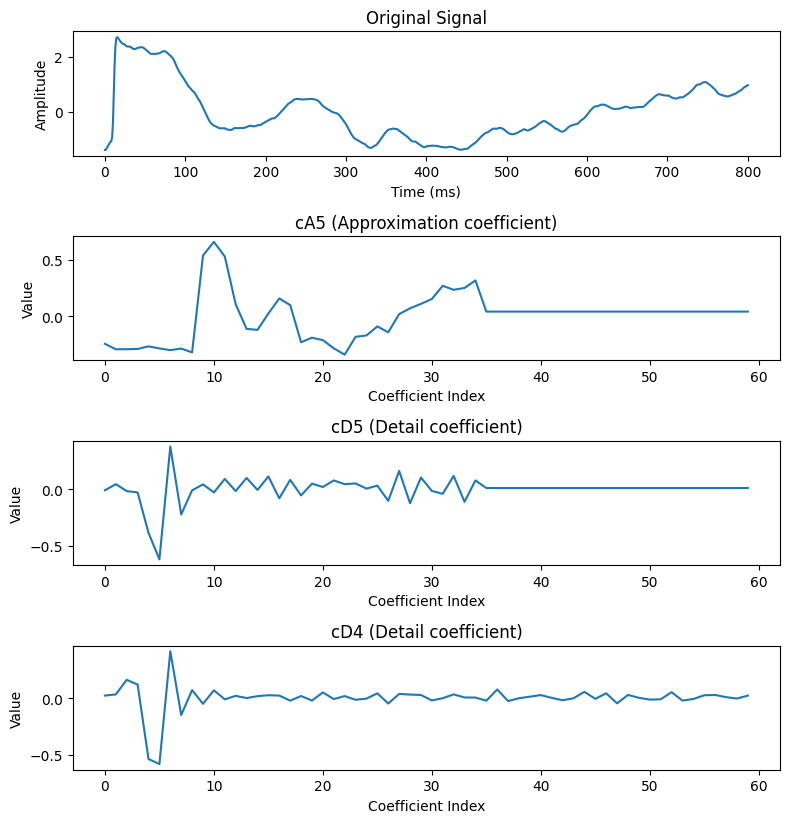

In [4]:
time, signal = process_file(prima_files_BC_and_RGC[0], t_max=200)
print("Shape of raw data:", signal.shape)


def extract_dwt_features(signal, wavelet='db6', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    #print("DWT Coefficients lengths before padding:", [len(c) for c in coeffs])
    # drop cD1 (highest-frequency detail) 
    coeffs = coeffs[:-3]  
    max_len = max(len(c) for c in coeffs)
    # Zero-pad each coefficient array to the same length
    padded = [np.pad(c, (0, max_len - len(c))) for c in coeffs]
    #print("DWT Coefficients lengths after padding:", [len(c) for c in padded])
    # scale each coefficient array to have zero mean and unit variance
    padded = [(c - np.mean(c)) / np.std(c) for c in padded]
    # scale to have 1 peak to-peak amplitude
    padded = [c / (np.max(c) - np.min(c)) for c in padded]
    return np.stack(padded, axis=0)

def get_coeff_names(level=4):
    coeff_names = [f"cA{level} (Approximation coefficient)"] + [f"cD{l} (Detail coefficient)" for l in range(level, 0, -1)]
    return coeff_names[:-3]  # drop cD1


dwt_coeffs = extract_dwt_features(signal, wavelet='db6', level=5)
dwt_coeff_names = get_coeff_names(level=5)

# plot the original signal and its DWT coefficients
plt.figure(figsize=(8, 12))
plt.subplot(6, 1, 1)
plt.title("Original Signal")
plt.plot(signal)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
for i, (coeff, name) in enumerate(zip(dwt_coeffs, dwt_coeff_names)):
    plt.subplot(6, 1, i+2)
    plt.plot(coeff)
    #plt.title(f"DWT Coefficient Level {i} {name}")
    plt.title(f"{name}")
    plt.xlabel("Coefficient Index")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

# 3. Test

--- Experiment 1 ---
Training samples: 117, batch size: 9, epochs: 30

--- Fold 1/10 ---
[Fold 1] Early stopped at epoch 30 → best epoch = 25, val_loss=0.1614, val_acc=1.0000, train_acc=0.9333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 30 → best epoch = 30, val_loss=0.2706, val_acc=0.9167, train_acc=0.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 23 → best epoch = 13, val_loss=0.4997, val_acc=0.6667, train_acc=0.9143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 28 → best epoch = 18, val_loss=0.5259, val_acc=0.9167, train_acc=0.8952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 30 → best epoch = 21, val_loss=0.3799, val_acc=0.8333, train_acc=0.9238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 16 → best epoch = 6, val_loss=0.6923, val_acc=0.6667, train_acc=0.7619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 30 → best epoch = 23, val_loss=0.4296, val_acc=0.7500, train_acc=0.9524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 30, val_loss=0.3121, val_acc=0.8182, train_acc=0.9811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 17 → best epoch = 7, val_loss=0.4462, val_acc=0.8182, train_acc=0.7736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 25 → best epoch = 15, val_loss=0.2959, val_acc=0.8182, train_acc=0.9057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)


SHAP values shape: [(60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3)]
Averaged SHAP values shape: (60, 2, 3)


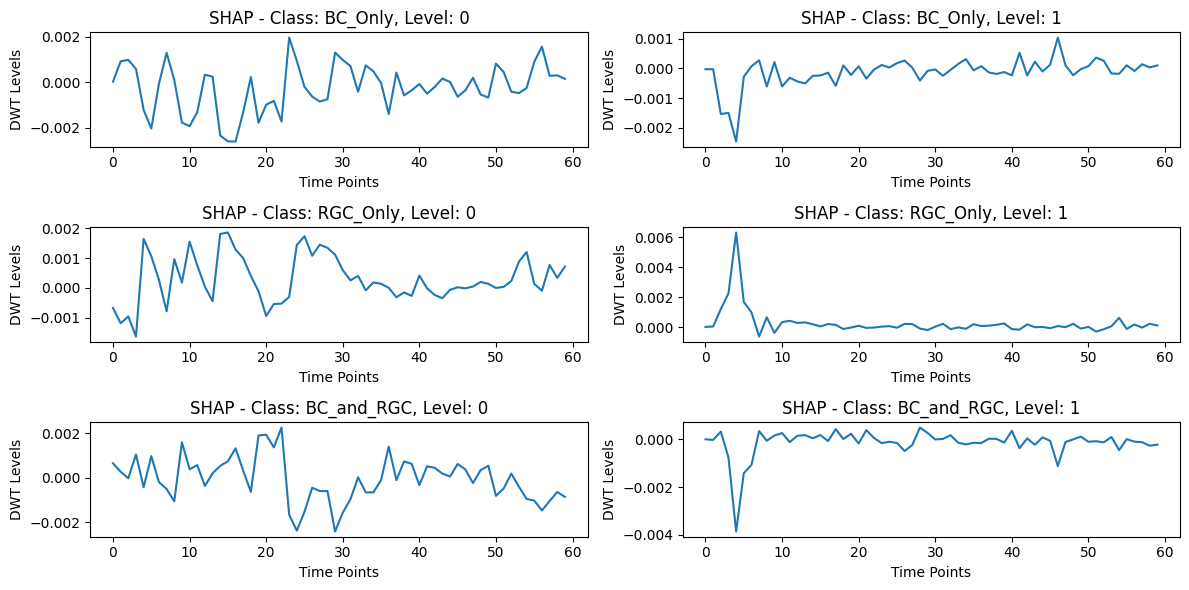

[[29  9  1]
 [10 29  0]
 [ 0  1 38]]
--- Experiment 2 ---
Training samples: 117, batch size: 9, epochs: 30

--- Fold 1/10 ---
[Fold 1] Early stopped at epoch 30 → best epoch = 29, val_loss=0.1318, val_acc=1.0000, train_acc=0.9238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 30 → best epoch = 23, val_loss=0.3119, val_acc=0.8333, train_acc=0.9238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 25 → best epoch = 15, val_loss=0.4479, val_acc=0.7500, train_acc=0.9048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 30 → best epoch = 20, val_loss=0.4285, val_acc=0.9167, train_acc=0.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 29 → best epoch = 19, val_loss=0.3956, val_acc=0.8333, train_acc=0.9238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 16 → best epoch = 6, val_loss=0.7734, val_acc=0.6667, train_acc=0.8190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 30 → best epoch = 26, val_loss=0.4272, val_acc=0.8333, train_acc=0.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 30, val_loss=0.3253, val_acc=0.8182, train_acc=0.9811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 18 → best epoch = 8, val_loss=0.4561, val_acc=0.8182, train_acc=0.8019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 30 → best epoch = 28, val_loss=0.2648, val_acc=0.8182, train_acc=0.9811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)


SHAP values shape: [(60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3)]
Averaged SHAP values shape: (60, 2, 3)


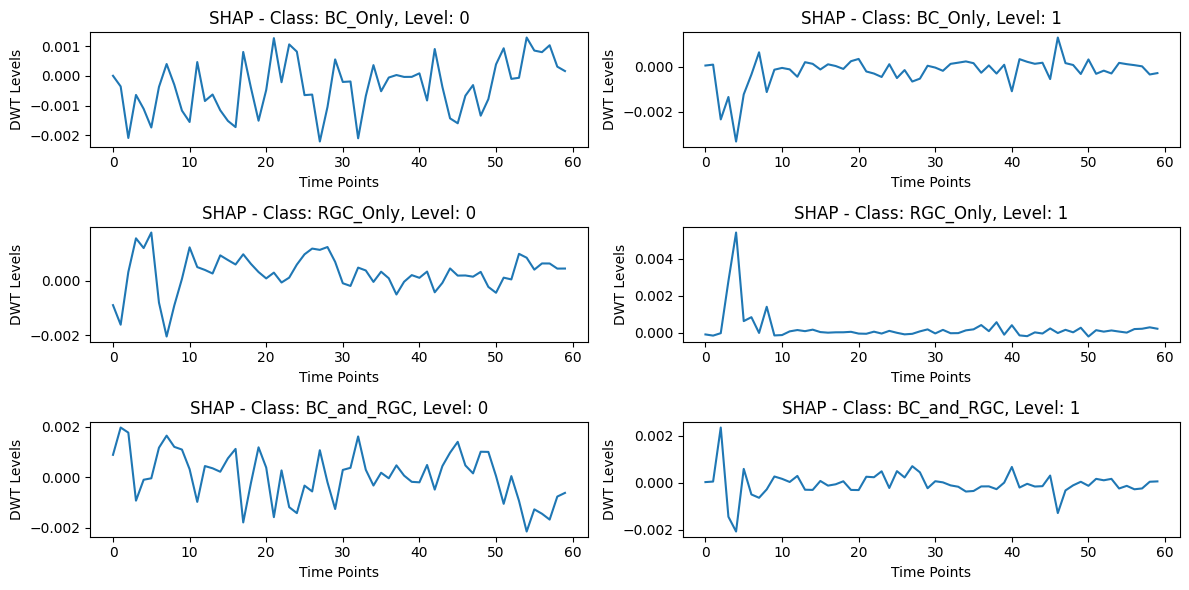

[[28  9  2]
 [ 8 31  0]
 [ 0  1 38]]
--- Experiment 3 ---
Training samples: 117, batch size: 9, epochs: 30

--- Fold 1/10 ---
[Fold 1] Early stopped at epoch 30 → best epoch = 28, val_loss=0.2485, val_acc=0.9167, train_acc=0.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 30 → best epoch = 26, val_loss=0.3111, val_acc=0.8333, train_acc=0.9619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 24 → best epoch = 14, val_loss=0.5105, val_acc=0.7500, train_acc=0.8857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 30 → best epoch = 29, val_loss=0.3776, val_acc=0.9167, train_acc=0.9524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 30 → best epoch = 25, val_loss=0.3780, val_acc=0.9167, train_acc=0.9238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 16 → best epoch = 6, val_loss=0.5829, val_acc=0.6667, train_acc=0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 30 → best epoch = 21, val_loss=0.4272, val_acc=0.7500, train_acc=0.8952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 28, val_loss=0.2994, val_acc=0.7273, train_acc=0.9717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 20 → best epoch = 10, val_loss=0.4230, val_acc=0.8182, train_acc=0.8302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 27 → best epoch = 17, val_loss=0.2616, val_acc=0.7273, train_acc=0.9434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)


SHAP values shape: [(60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3)]
Averaged SHAP values shape: (60, 2, 3)


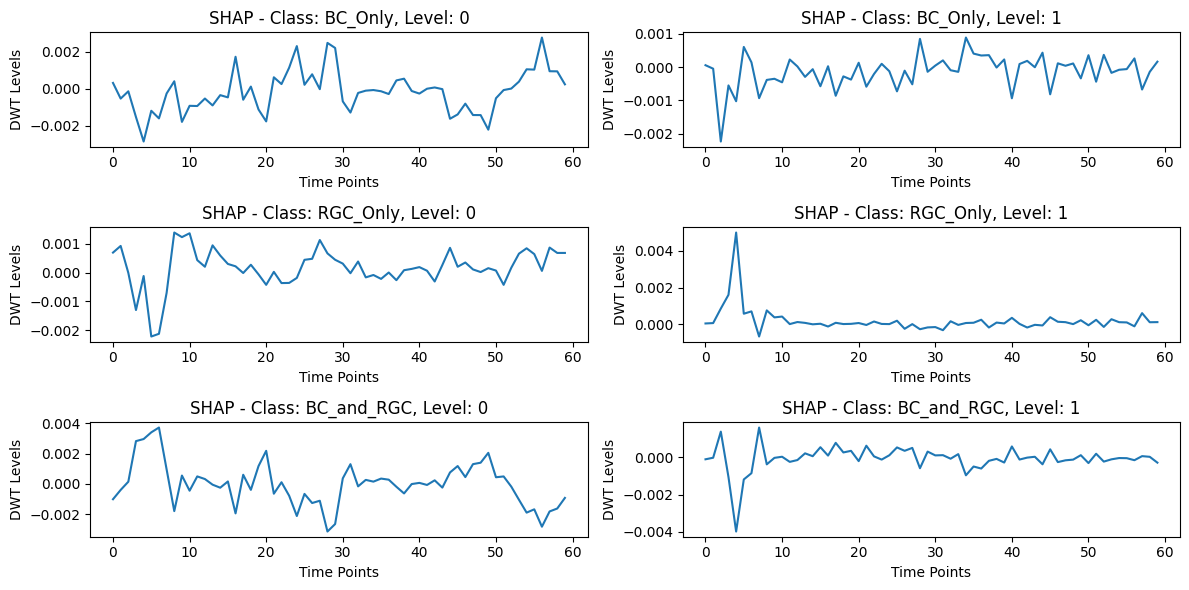

[[29  9  1]
 [11 28  0]
 [ 1  1 37]]
--- Experiment 4 ---
Training samples: 117, batch size: 9, epochs: 30

--- Fold 1/10 ---
[Fold 1] Early stopped at epoch 30 → best epoch = 30, val_loss=0.1759, val_acc=1.0000, train_acc=0.9524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 30 → best epoch = 26, val_loss=0.2547, val_acc=0.7500, train_acc=0.9714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 18 → best epoch = 8, val_loss=0.5751, val_acc=0.6667, train_acc=0.7905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 26 → best epoch = 16, val_loss=0.4190, val_acc=0.9167, train_acc=0.8762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 26 → best epoch = 16, val_loss=0.4377, val_acc=0.8333, train_acc=0.9333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 16 → best epoch = 6, val_loss=0.7844, val_acc=0.6667, train_acc=0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 30 → best epoch = 21, val_loss=0.4203, val_acc=0.8333, train_acc=0.9333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 29, val_loss=0.2736, val_acc=0.9091, train_acc=0.9434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 19 → best epoch = 9, val_loss=0.4406, val_acc=0.8182, train_acc=0.8019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 30 → best epoch = 21, val_loss=0.3007, val_acc=0.8182, train_acc=0.9057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)


SHAP values shape: [(60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3)]
Averaged SHAP values shape: (60, 2, 3)


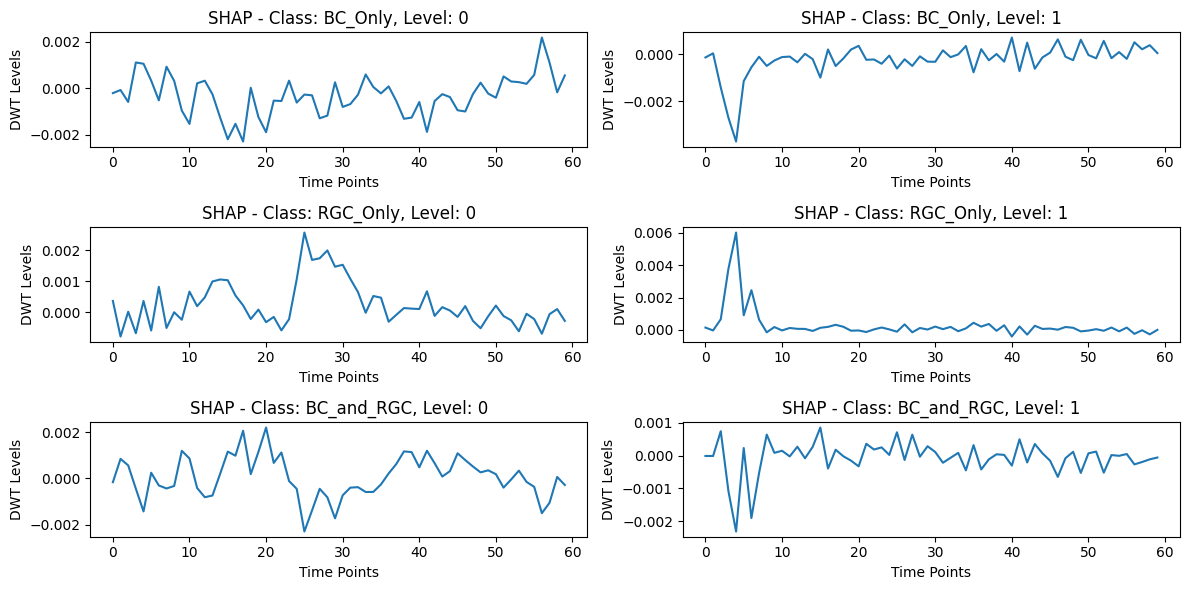

[[27 10  2]
 [ 7 31  1]
 [ 0  1 38]]
--- Experiment 5 ---
Training samples: 117, batch size: 9, epochs: 30

--- Fold 1/10 ---
[Fold 1] Early stopped at epoch 30 → best epoch = 29, val_loss=0.1318, val_acc=1.0000, train_acc=0.9619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 2/10 ---
[Fold 2] Early stopped at epoch 30 → best epoch = 25, val_loss=0.3843, val_acc=0.8333, train_acc=0.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 3/10 ---
[Fold 3] Early stopped at epoch 24 → best epoch = 14, val_loss=0.4184, val_acc=0.7500, train_acc=0.8286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 4/10 ---
[Fold 4] Early stopped at epoch 30 → best epoch = 22, val_loss=0.5860, val_acc=0.9167, train_acc=0.9048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 5/10 ---
[Fold 5] Early stopped at epoch 30 → best epoch = 26, val_loss=0.4216, val_acc=0.8333, train_acc=0.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 6/10 ---
[Fold 6] Early stopped at epoch 14 → best epoch = 4, val_loss=0.8800, val_acc=0.5833, train_acc=0.7524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 7/10 ---
[Fold 7] Early stopped at epoch 30 → best epoch = 28, val_loss=0.4228, val_acc=0.8333, train_acc=0.9238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 8/10 ---
[Fold 8] Early stopped at epoch 30 → best epoch = 22, val_loss=0.3091, val_acc=0.8182, train_acc=0.8962
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 9/10 ---
[Fold 9] Early stopped at epoch 18 → best epoch = 8, val_loss=0.4366, val_acc=0.8182, train_acc=0.8113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)



--- Fold 10/10 ---
[Fold 10] Early stopped at epoch 21 → best epoch = 11, val_loss=0.3359, val_acc=0.8182, train_acc=0.8585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(11, 60, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 60, 2))']
  warnings.warn(msg)


SHAP values shape: [(60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3), (60, 2, 3)]
Averaged SHAP values shape: (60, 2, 3)


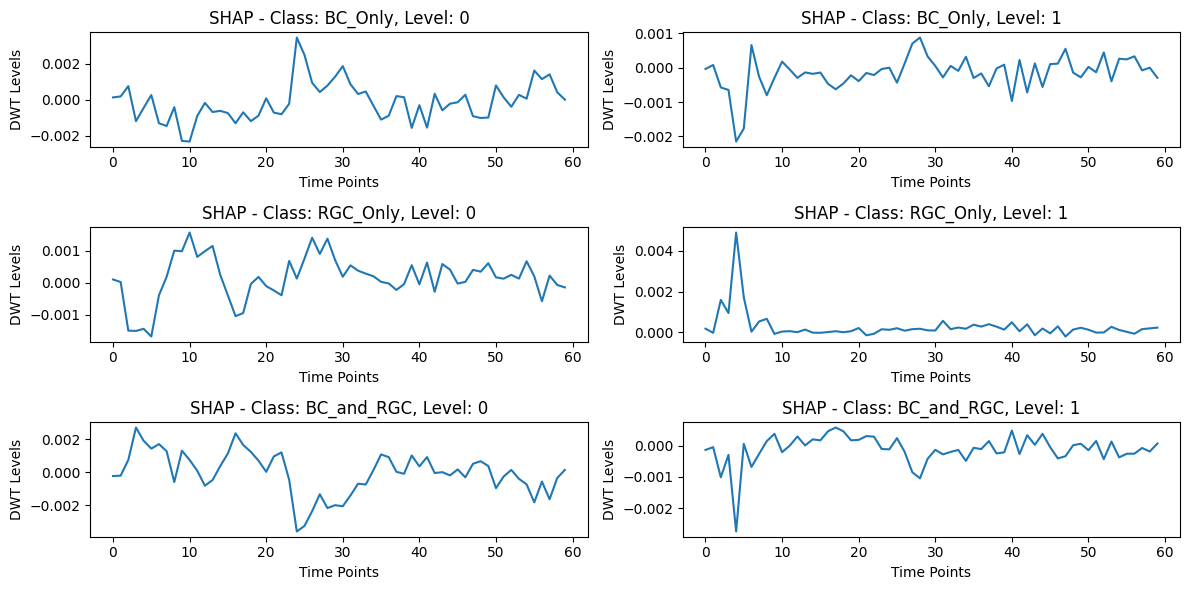

[[29  8  2]
 [10 29  0]
 [ 0  1 38]]


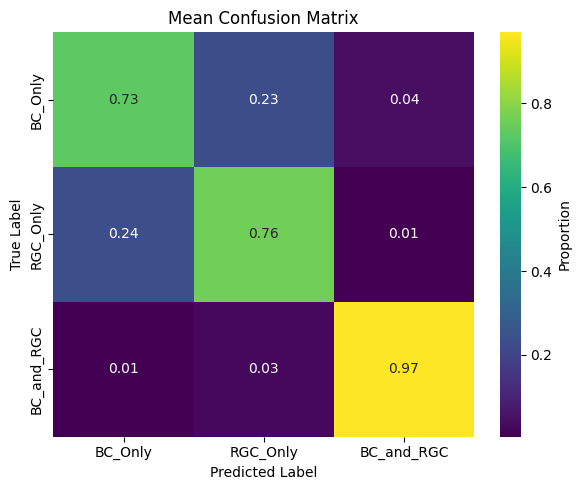

In [5]:
all_files_BC_only = prima_files_BC_only + mp20_files_BC_only
all_files_RGC_only = prima_files_RGC_only + mp20_files_RGC_only
all_files_BC_and_RGC = prima_files_BC_and_RGC + mp20_files_BC_and_RGC

average_results = {}
results = []
mean_shap_values = []
all_conf_matrices = []
for experiments in range(5):
    print(f"--- Experiment {experiments + 1} ---")
    np.random.seed(42)
    no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
    sampled_BC = np.random.choice(prima_files_BC_only, no_files, replace=False)
    sampled_RGC = np.random.choice(prima_files_RGC_only, no_files, replace=False)
    sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)
    # no_files = min(len(all_files_BC_only), len(all_files_RGC_only), len(all_files_BC_and_RGC))
    # sampled_BC = np.random.choice(all_files_BC_only, no_files, replace=False)
    # sampled_RGC = np.random.choice(all_files_RGC_only, no_files, replace=False)
    # sampled_BC_and_RGC = np.random.choice(all_files_BC_and_RGC, no_files, replace=False)

    X, labels = [], []
    for file in sampled_BC:
        _, signal = process_file(file, t_max=200)
        X.append(extract_dwt_features(signal, wavelet='db6', level=4))
        labels.append("BC_Only")

    for file in sampled_RGC:
        _, signal = process_file(file, t_max=200)
        X.append(extract_dwt_features(signal, wavelet='db6', level=4))
        labels.append("RGC_Only")

    for file in sampled_BC_and_RGC:
        _, signal = process_file(file, t_max=200)
        X.append(extract_dwt_features(signal, wavelet='db6', level=4))
        labels.append("BC_and_RGC")
    X = np.stack(X, axis=0)                     # (n_samples, n_levels, n_points)
    X = np.transpose(X, (0, 2, 1)).astype('float32')  # (n_samples, n_points, n_levels)


    n_train = len(X)
    batch_size = max(4, min(32, n_train // 12))
    if n_train < 100:
        epochs = 50
    else:
        epochs = 30
    print(f"Training samples: {n_train}, batch size: {batch_size}, epochs: {epochs}")

    clf = Multichannel_1DCNN()
    y_true, y_pred, shap_values = clf.fit_nfoldcv(X=X, y=labels, n_splits=10, random_state=42, epochs=epochs, batch_size=batch_size)
    print("SHAP values shape:", [sv.shape for sv in shap_values])
    # average over folds
    shap_values = np.mean(shap_values, axis=0) # dimension (200, 4, 3) = (n_points, n_levels, n_classes)
    print("Averaged SHAP values shape:", shap_values.shape) 
    mean_shap_values.append(shap_values)

    plt.figure(figsize=(12, 6))
    class_names = ["BC_Only", "RGC_Only", "BC_and_RGC"]
    for i, class_name in enumerate(class_names):
        for j in range(shap_values.shape[1]):
            plt.subplot(len(class_names), shap_values.shape[1], i * shap_values.shape[1] + j + 1)
            plt.title(f"SHAP - Class: {class_name}, Level: {j}")
            plt.plot(shap_values[:, :, i][:, j])
            plt.xlabel("Time Points")
            plt.ylabel("DWT Levels")
    plt.tight_layout()
    plt.show()

    unique_labels = np.unique(labels)
    metrics = clf.evaluate(y_true, y_pred)

    results.append({
            "Accuracy": metrics["accuracy"],
            "BalancedAcc": metrics["balanced_accuracy"],
            "F1": metrics["f1_score"],
            "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
            "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
            "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
        })
    all_conf_matrices.append(
        confusion_matrix(
            y_true, y_pred, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
        )
    )

accs = [r["Accuracy"] for r in results]
balanced_accs = [r["BalancedAcc"] for r in results]
f1s = [r["F1"] for r in results]
bc_accs = [float(r["Acc BC_Only"]) for r in results]
rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

average_results = {
    "Accuracy_mean": np.mean(accs),
    "Accuracy_std": np.std(accs),
    "BalancedAcc_mean": np.mean(balanced_accs),
    "BalancedAcc_std": np.std(balanced_accs),
    "F1_mean": np.mean(f1s),
    "F1_std": np.std(f1s),

    # per-class accuracies (recall)
    "Acc_BC_Only_mean": np.mean(bc_accs),
    "Acc_BC_Only_std": np.std(bc_accs),
    "Acc_RGC_Only_mean": np.mean(rgc_accs),
    "Acc_RGC_Only_std": np.std(rgc_accs),
    "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
    "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
}
mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

labels = ["BC_Only", "RGC_Only", "BC_and_RGC"] 
plt.figure(figsize=(6,5)) 
sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'}) 
plt.title(f"Mean Confusion Matrix") 
plt.xlabel("Predicted Label") 
plt.ylabel("True Label") 
plt.tight_layout()
plt.show()

In [6]:
# compute and print average results
print("Average Results over 10 experiments:")
for k, v in average_results.items():
    print(f"{k}: {v:.4f}")

Average Results over 10 experiments:
Accuracy_mean: 0.8188
Accuracy_std: 0.0084
BalancedAcc_mean: 0.8188
BalancedAcc_std: 0.0084
F1_mean: 0.8182
F1_std: 0.0076
Acc_BC_Only_mean: 0.7282
Acc_BC_Only_std: 0.0205
Acc_RGC_Only_mean: 0.7590
Acc_RGC_Only_std: 0.0308
Acc_BC_and_RGC_mean: 0.9692
Acc_BC_and_RGC_std: 0.0103


# 4.Explain

Global mean SHAP shape: (60, 2, 3)
SHAP thresholds per class at 98 percentile: [0.00164029 0.00131516 0.00184769]


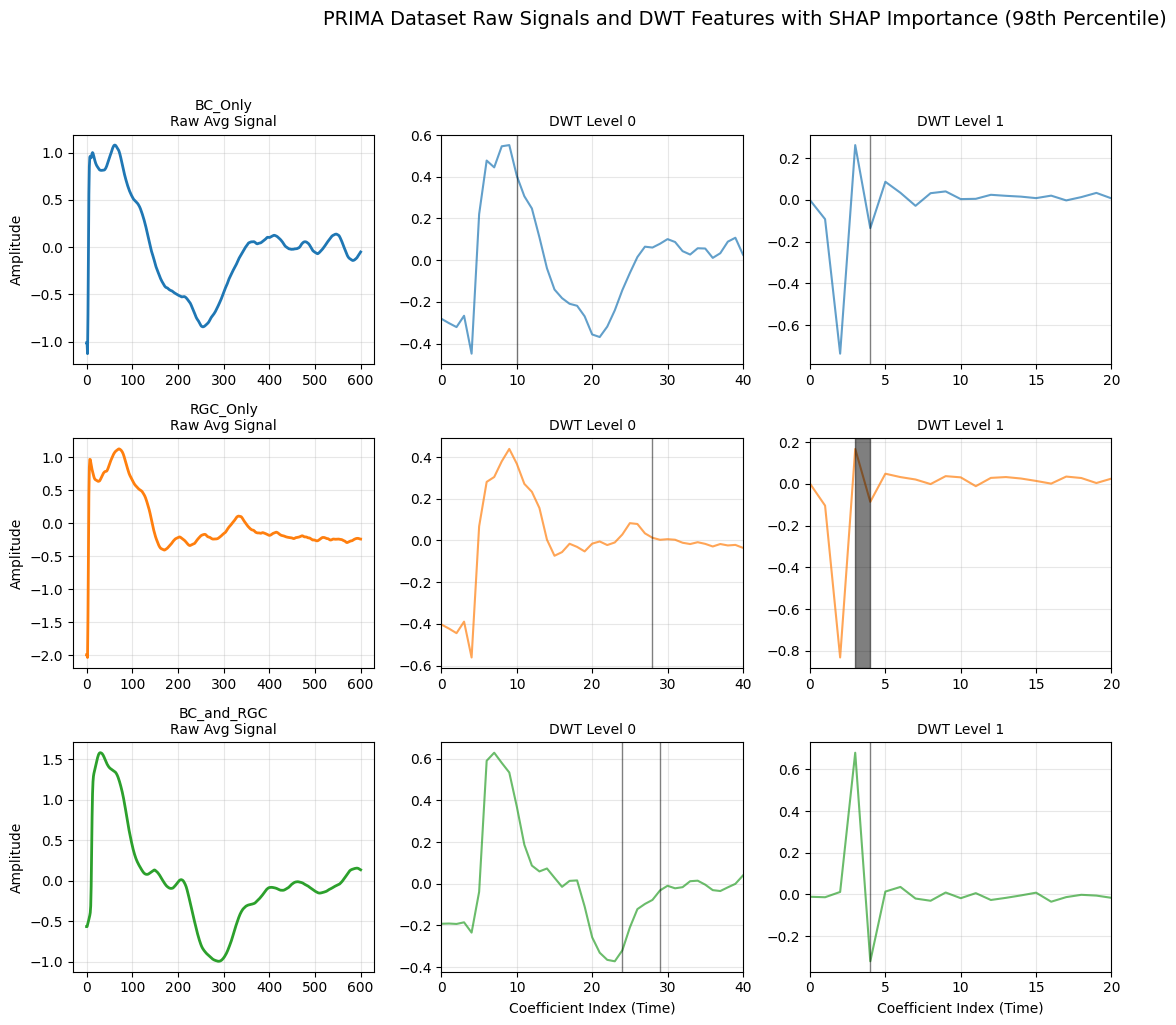

In [7]:
N_LEVELS = 3
ABS_SHAP_THRESHOLD_PERCENTILE = 98
# Average SHAP values across all experiments 
mean_shap_values_global = np.mean(np.stack(mean_shap_values, axis=0), axis=0) # shape (n_points, n_levels, n_classes) 
print("Global mean SHAP shape:", mean_shap_values_global.shape) 
# find 98th percentile threshold for each class
shap_thresholds = np.percentile(np.abs(mean_shap_values_global), ABS_SHAP_THRESHOLD_PERCENTILE, axis=(0, 1))
print("SHAP thresholds per class at", ABS_SHAP_THRESHOLD_PERCENTILE, "percentile:", shap_thresholds)

mean_signals = {} 
mean_signals["BC_Only"] = avg_BC_sig 
mean_signals["RGC_Only"] = avg_RGC_sig 
mean_signals["BC_and_RGC"] = avg_BC_RGC_sig 
mean_dwt_features = {} 
mean_dwt_features["BC_Only"] = extract_dwt_features(avg_BC_sig, wavelet='db4', level=4) 
mean_dwt_features["RGC_Only"] = extract_dwt_features(avg_RGC_sig, wavelet='db4', level=4) 
mean_dwt_features["BC_and_RGC"] = extract_dwt_features(avg_BC_RGC_sig, wavelet='db4', level=4) 

def plot_mean_signals_and_dwt(mean_signals, mean_dwt_features, mean_shap_values_global, shap_thresholds, 
                              dataset_name="Dataset", N_LEVELS=3, ABS_SHAP_THRESHOLD_PERCENTILE=98):
    label_colors = {
        "BC_Only": 'C0',  # Blue
        "RGC_Only": 'C1', # Orange
        "BC_and_RGC": 'C2' # Green
    }
    unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

    # Define level-specific x-axis limits
    level_xlim = {0: (0, 40), 1: (0, 20), 2: (0, 20)}

    plt.figure(figsize=(15, 10))
    for c_idx, class_label in enumerate(unique_labels):
        # --- Get class-specific data ---
        avg_sig = mean_signals[class_label]                  # (N_points,)
        avg_dwt = mean_dwt_features[class_label]             # (N_levels, N_points)
        mean_shap_c = mean_shap_values_global[:, :, c_idx]   # (N_points, N_levels)
        color = label_colors[class_label]

        # --- Plot raw signal (first column) ---
        ax_raw = plt.subplot(len(unique_labels), N_LEVELS + 1, c_idx * (N_LEVELS + 1) + 1)
        ax_raw.plot(avg_sig, color=color, lw=2)
        ax_raw.set_title(f"{class_label}\nRaw Avg Signal", fontsize=10)
        ax_raw.set_ylabel("Amplitude")
        ax_raw.grid(True, alpha=0.3)

        # --- Plot DWT levels ---
        #for l_idx in range(N_LEVELS):
        for l_idx in range(min(N_LEVELS, avg_dwt.shape[0])):
            ax_dwt = plt.subplot(len(unique_labels), N_LEVELS + 1, c_idx * (N_LEVELS + 1) + 2 + l_idx)

            # Set x-axis window depending on level
            if l_idx in level_xlim:
                ax_dwt.set_xlim(*level_xlim[l_idx])
            else:
                ax_dwt.set_xlim(0, 80)  

            dwt_level_sig = avg_dwt[l_idx, :]
            shap_level_vals = mean_shap_c[:, l_idx]

            # Plot DWT
            ax_dwt.plot(dwt_level_sig, color=color, alpha=0.7)
            ax_dwt.set_title(f"DWT Level {l_idx}", fontsize=10)
            ax_dwt.grid(True, alpha=0.3)

            # Highlight SHAP regions
            abs_shap = np.abs(shap_level_vals)
            important_indices = np.where(abs_shap >= shap_thresholds[c_idx])[0]

            if important_indices.size > 0:
                # Merge continuous segments
                segments = []
                start = important_indices[0]
                end = important_indices[0]
                for i in range(1, len(important_indices)):
                    if important_indices[i] == important_indices[i-1] + 1:
                        end = important_indices[i]
                    else:
                        segments.append((start, end))
                        start = important_indices[i]
                        end = important_indices[i]
                segments.append((start, end))

                # Draw shaded regions
                for start, end in segments:
                    ax_dwt.axvspan(start, end, alpha=0.5, color='k', zorder=10)

            if c_idx == len(unique_labels) - 1:
                ax_dwt.set_xlabel("Coefficient Index (Time)")

    plt.suptitle(f"{dataset_name} Raw Signals and DWT Features with SHAP Importance "
                 f"({ABS_SHAP_THRESHOLD_PERCENTILE}th Percentile)",
                 fontsize=14, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

plot_mean_signals_and_dwt(mean_signals, mean_dwt_features, mean_shap_values_global, shap_thresholds, 
                          dataset_name="PRIMA Dataset", N_LEVELS=3, ABS_SHAP_THRESHOLD_PERCENTILE=98)

## 5. Train / Test = Prima / MP20

--- Experiment 1 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.4274 |     0.4259
    2 |     0.6068 |     0.6111
    3 |     0.7179 |     0.6481
    4 |     0.7179 |     0.6296
    5 |     0.7607 |     0.7037
    6 |     0.8205 |     0.5556
    7 |     0.7778 |     0.7037
    8 |     0.8547 |     0.6111
    9 |     0.7778 |     0.6852
   10 |     0.8034 |     0.6296
   11 |     0.8376 |     0.7037
   12 |     0.8547 |     0.6667
   13 |     0.8803 |     0.6481
   14 |     0.8718 |     0.6852
   15 |     0.8889 |     0.7037
   16 |     0.8632 |     0.7037
   17 |     0.8889 |     0.7037
   18 |     0.9231 |     0.7037
   19 |     0.9316 |     0.7222
   20 |     0.9316 |     0.6852
   21 |     0.9316 |     0.6852
   22 |     0.9487 |     0.7222
   23 |     0.9573 |     0.7037
   24 |     0.9658 |     0.7037
 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_9
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_9
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


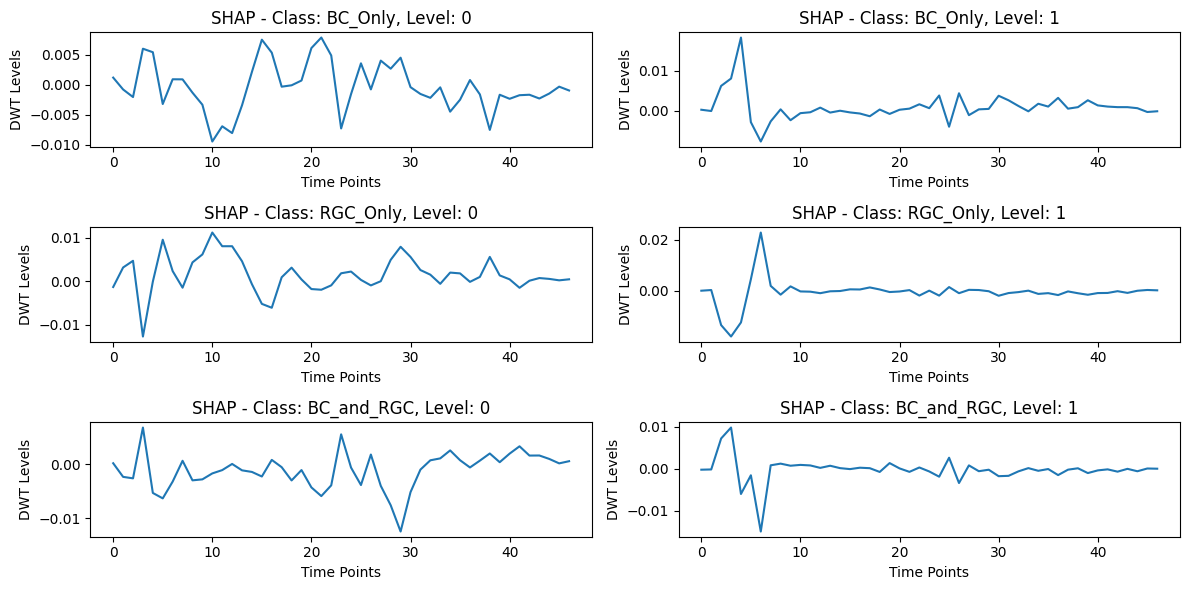

[[11  6  1]
 [10  8  0]
 [ 1  0 17]]
--- Experiment 2 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.3846 |     0.4259
    2 |     0.7094 |     0.7037
    3 |     0.7350 |     0.5370
    4 |     0.7692 |     0.5741
    5 |     0.7863 |     0.4074
    6 |     0.7521 |     0.5185
    7 |     0.8205 |     0.6111
    8 |     0.8205 |     0.6111
    9 |     0.8291 |     0.5926
   10 |     0.8291 |     0.6296
   11 |     0.8718 |     0.6481
   12 |     0.8718 |     0.6111
   13 |     0.8462 |     0.6111
   14 |     0.8547 |     0.5926
   15 |     0.8718 |     0.6296
   16 |     0.8462 |     0.6111
   17 |     0.9060 |     0.6296
   18 |     0.8803 |     0.6111
   19 |     0.8718 |     0.6481
   20 |     0.8974 |     0.6481
   21 |     0.8974 |     0.6667
   22 |     0.8974 |     0.6111
   23 |     0.9145 |     0.6

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_18
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_18
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


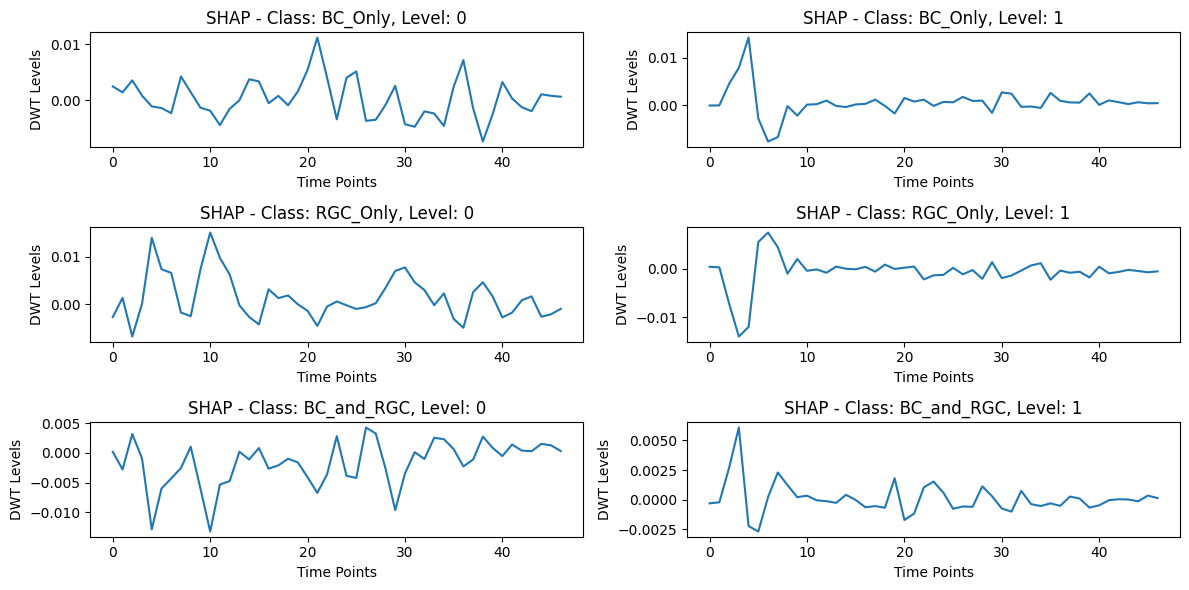

[[11  5  2]
 [12  6  0]
 [ 1  1 16]]
--- Experiment 3 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.4444 |     0.5185
    2 |     0.6154 |     0.5370
    3 |     0.7436 |     0.3333
    4 |     0.7949 |     0.5000
    5 |     0.7692 |     0.5185
    6 |     0.7607 |     0.5556
    7 |     0.8120 |     0.5556
    8 |     0.8291 |     0.5741
    9 |     0.8376 |     0.6111
   10 |     0.8120 |     0.6111
   11 |     0.8803 |     0.6667
   12 |     0.8291 |     0.5926
   13 |     0.8462 |     0.6111
   14 |     0.8889 |     0.6111
   15 |     0.8803 |     0.6111
   16 |     0.8974 |     0.5556
   17 |     0.8291 |     0.5926
   18 |     0.8889 |     0.6481
   19 |     0.8718 |     0.5741
   20 |     0.8718 |     0.6296
   21 |     0.8974 |     0.5370
   22 |     0.9316 |     0.5926
   23 |     0.8803 |     0.6

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_27
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_27
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


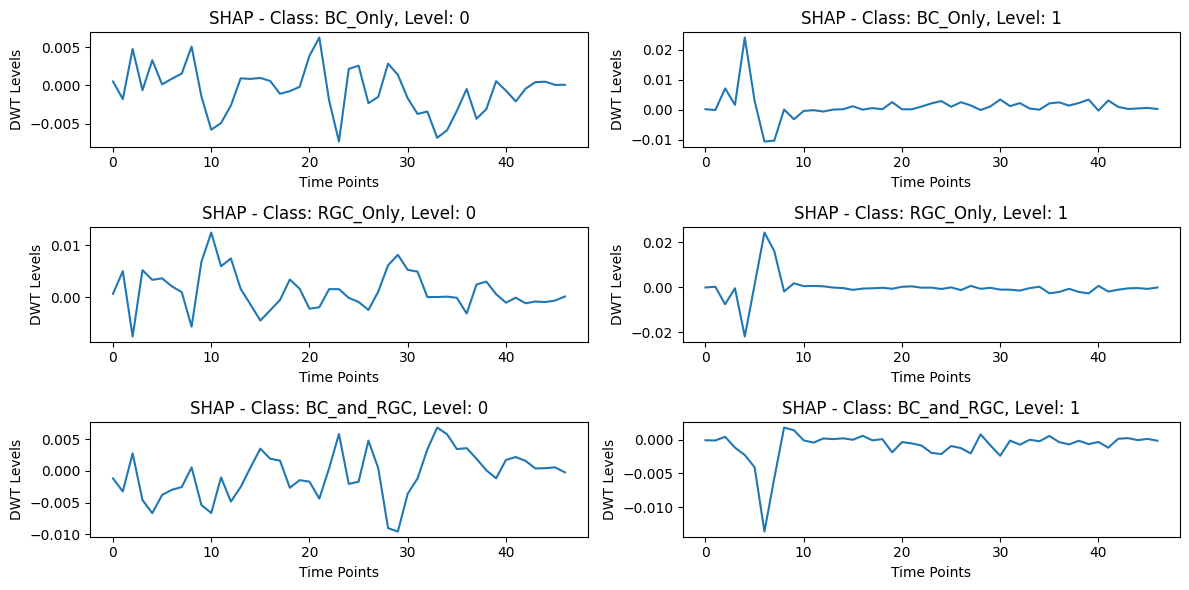

[[11  5  2]
 [10  8  0]
 [ 1  0 17]]
--- Experiment 4 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.5214 |     0.5000
    2 |     0.7179 |     0.4444
    3 |     0.7778 |     0.6296
    4 |     0.7692 |     0.6296
    5 |     0.7265 |     0.6111
    6 |     0.7778 |     0.6111
    7 |     0.8120 |     0.6296
    8 |     0.8547 |     0.6481
    9 |     0.8462 |     0.6111
   10 |     0.8889 |     0.6296
   11 |     0.8376 |     0.6296
   12 |     0.8718 |     0.6481
   13 |     0.8632 |     0.6111
   14 |     0.8974 |     0.6296
   15 |     0.8718 |     0.6481
   16 |     0.9145 |     0.6296
   17 |     0.8974 |     0.6296
   18 |     0.8889 |     0.6296
   19 |     0.8803 |     0.6667
   20 |     0.8974 |     0.6667
   21 |     0.9060 |     0.6852
   22 |     0.9316 |     0.6296
   23 |     0.9316 |     0.6

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_36
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_36
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


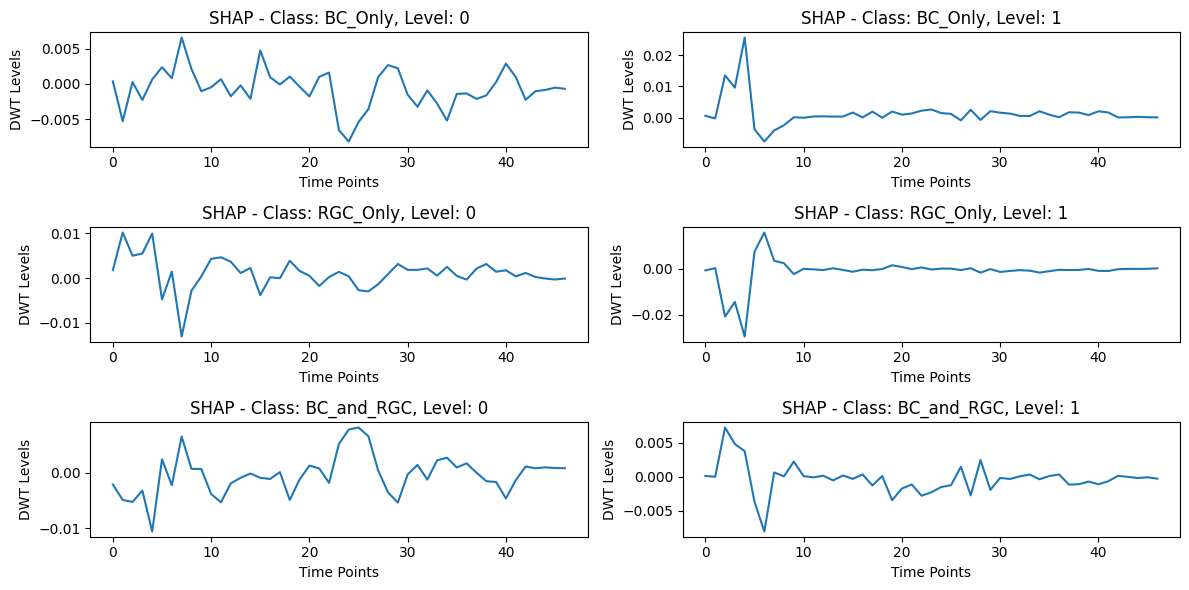

[[10  8  0]
 [ 9  9  0]
 [ 3  0 15]]
--- Experiment 5 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.4530 |     0.3704
    2 |     0.7009 |     0.3889
    3 |     0.7009 |     0.4630
    4 |     0.7350 |     0.5000
    5 |     0.7607 |     0.4815
    6 |     0.7949 |     0.4630
    7 |     0.8034 |     0.5926
    8 |     0.8462 |     0.5000
    9 |     0.8291 |     0.5926
   10 |     0.8462 |     0.5926
   11 |     0.8803 |     0.6481
   12 |     0.8034 |     0.6111
   13 |     0.8462 |     0.6111
   14 |     0.8547 |     0.6111
   15 |     0.8547 |     0.6111
   16 |     0.8974 |     0.5926
   17 |     0.8632 |     0.6111
   18 |     0.8889 |     0.6111
   19 |     0.8889 |     0.6296
   20 |     0.8889 |     0.6296
   21 |     0.8889 |     0.6667
   22 |     0.8974 |     0.6296
   23 |     0.9145 |     0.6

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_45
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_45
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


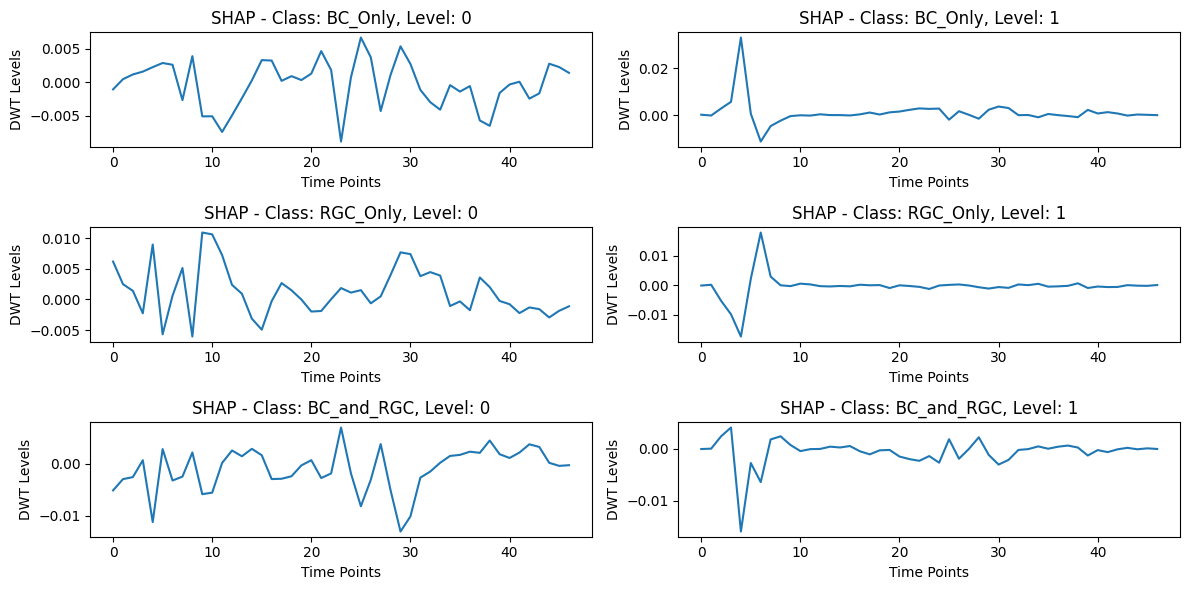

[[ 8  7  3]
 [ 9  9  0]
 [ 1  1 16]]
--- Experiment 6 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.4701 |     0.3148
    2 |     0.6154 |     0.3333
    3 |     0.7094 |     0.5000
    4 |     0.7009 |     0.3704
    5 |     0.7778 |     0.4630
    6 |     0.7436 |     0.4630
    7 |     0.7350 |     0.5556
    8 |     0.7692 |     0.5926
    9 |     0.7778 |     0.6111
   10 |     0.8462 |     0.5556
   11 |     0.8376 |     0.6111
   12 |     0.7949 |     0.6481
   13 |     0.8205 |     0.6296
   14 |     0.8718 |     0.6667
   15 |     0.8718 |     0.6852
   16 |     0.8632 |     0.6852
   17 |     0.8547 |     0.6667
   18 |     0.8974 |     0.6852
   19 |     0.8632 |     0.6667
   20 |     0.8889 |     0.6481
   21 |     0.8974 |     0.6667
   22 |     0.9402 |     0.6667
   23 |     0.8718 |     0.6

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_54
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_54
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


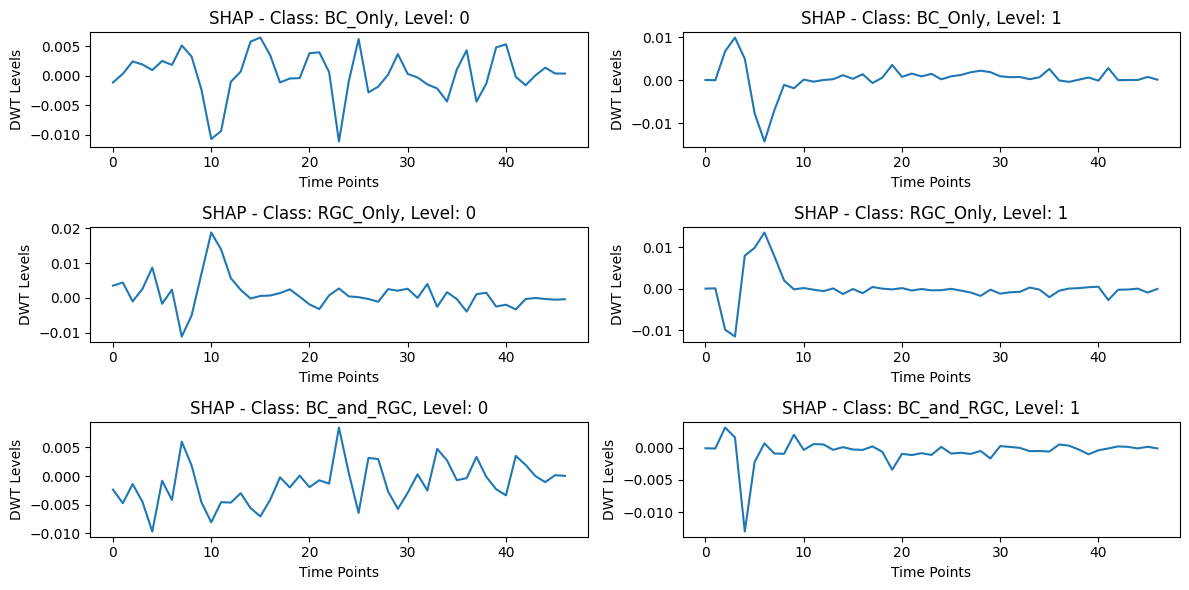

[[12  4  2]
 [10  8  0]
 [ 1  0 17]]
--- Experiment 7 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.3077 |     0.3519
    2 |     0.5897 |     0.4444
    3 |     0.7179 |     0.3889
    4 |     0.7094 |     0.4074
    5 |     0.7692 |     0.3704
    6 |     0.8291 |     0.3704
    7 |     0.7692 |     0.5000
    8 |     0.7949 |     0.3889
    9 |     0.8718 |     0.5556
   10 |     0.8632 |     0.5926
   11 |     0.9060 |     0.5741
   12 |     0.8718 |     0.5556
   13 |     0.8718 |     0.5556
   14 |     0.9145 |     0.5370
   15 |     0.8974 |     0.5370
   16 |     0.8718 |     0.6111
   17 |     0.9145 |     0.5370
   18 |     0.9060 |     0.5926
   19 |     0.9231 |     0.4815
   20 |     0.9145 |     0.5926
   21 |     0.9402 |     0.5370
   22 |     0.8974 |     0.5926
   23 |     0.9145 |     0.4

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_63
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_63
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


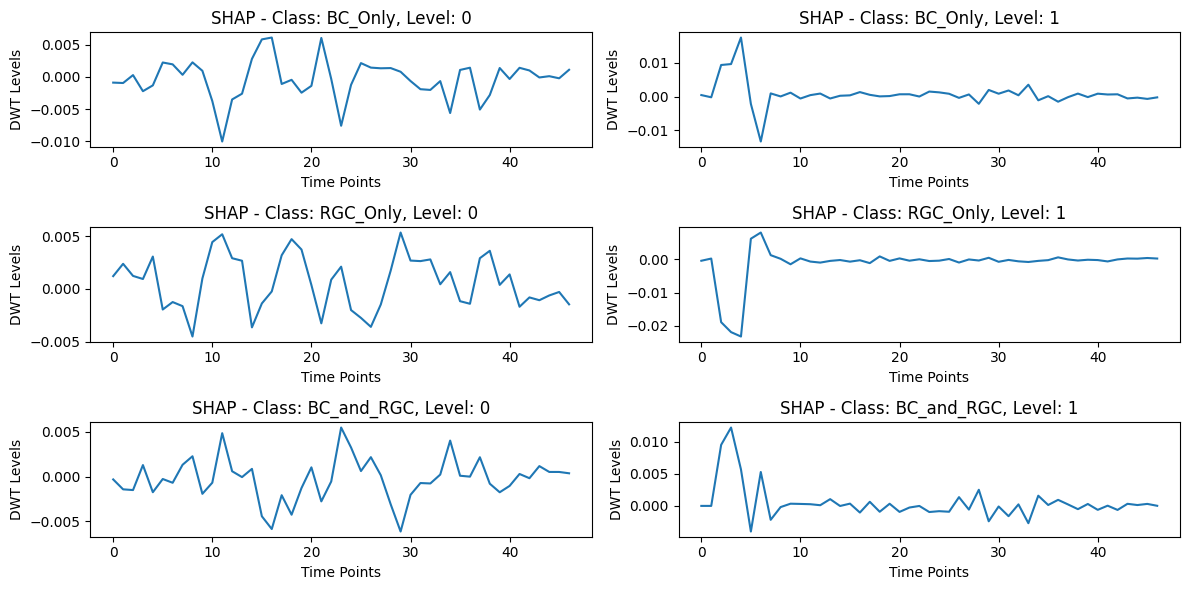

[[11  6  1]
 [12  6  0]
 [ 1  2 15]]
--- Experiment 8 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.4530 |     0.2407
    2 |     0.6154 |     0.4444
    3 |     0.7094 |     0.6667
    4 |     0.7778 |     0.6111
    5 |     0.7778 |     0.6481
    6 |     0.8034 |     0.5741
    7 |     0.7778 |     0.6852
    8 |     0.8291 |     0.5926
    9 |     0.8205 |     0.5000
   10 |     0.8803 |     0.5370
   11 |     0.8632 |     0.6481
   12 |     0.8889 |     0.5556
   13 |     0.8376 |     0.5556
   14 |     0.8889 |     0.4630
   15 |     0.8803 |     0.6111
   16 |     0.8718 |     0.5370
   17 |     0.8803 |     0.5926
   18 |     0.8889 |     0.5556
   19 |     0.9231 |     0.5370
   20 |     0.9060 |     0.5370
   21 |     0.9145 |     0.5926
   22 |     0.9231 |     0.5926
   23 |     0.9402 |     0.5

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_72
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_72
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


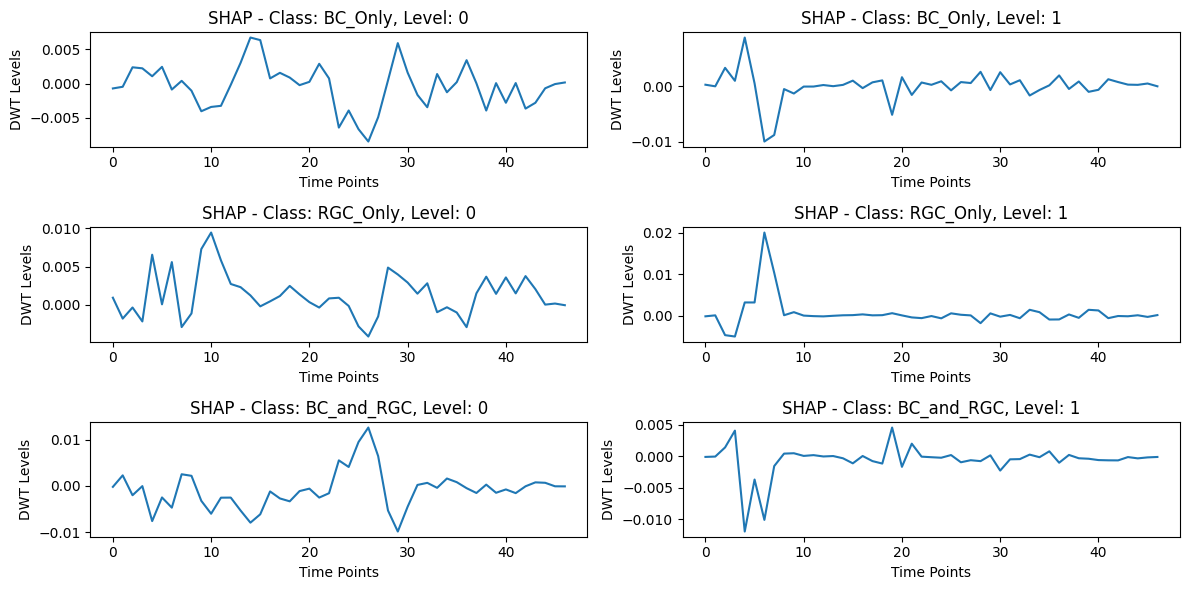

[[ 7 10  1]
 [10  8  0]
 [ 1  0 17]]
--- Experiment 9 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.4103 |     0.3704
    2 |     0.5641 |     0.6667
    3 |     0.7179 |     0.5926
    4 |     0.7521 |     0.5741
    5 |     0.7949 |     0.6481
    6 |     0.7692 |     0.6111
    7 |     0.8205 |     0.6852
    8 |     0.7778 |     0.6852
    9 |     0.8034 |     0.5926
   10 |     0.7863 |     0.6296
   11 |     0.7949 |     0.6296
   12 |     0.8205 |     0.6481
   13 |     0.8376 |     0.6667
   14 |     0.8205 |     0.6667
   15 |     0.8547 |     0.6296
   16 |     0.8462 |     0.7037
   17 |     0.8718 |     0.6111
   18 |     0.8547 |     0.7037
   19 |     0.8632 |     0.7037
   20 |     0.8974 |     0.7037
   21 |     0.8718 |     0.5926
   22 |     0.8718 |     0.6852
   23 |     0.8974 |     0.6

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_81
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_81
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


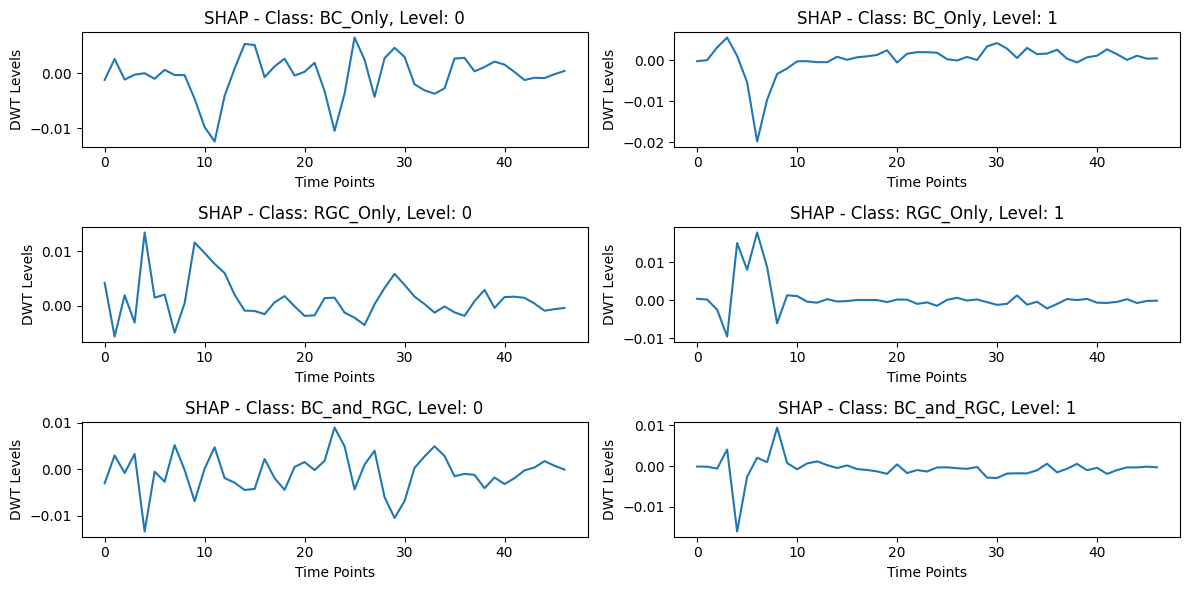

[[10  7  1]
 [ 8 10  0]
 [ 0  0 18]]
--- Experiment 10 ---
Training samples: 117, batch size: 9, epochs: 50, n_BC_train: 39, n_RGC_train: 39, n_BC_and_RGC_train: 39
Testing samples: 54, n_BC_test: 18, n_RGC_test: 18, n_BC_and_RGC_test: 18
Model output shape: (None, 3)
    1 |     0.5385 |     0.5556
    2 |     0.6838 |     0.6111
    3 |     0.7692 |     0.6852
    4 |     0.7692 |     0.7037
    5 |     0.8120 |     0.7222
    6 |     0.8291 |     0.6852
    7 |     0.8376 |     0.6667
    8 |     0.8462 |     0.7407
    9 |     0.9060 |     0.6667
   10 |     0.8632 |     0.7222
   11 |     0.8889 |     0.7222
   12 |     0.8974 |     0.6667
   13 |     0.9231 |     0.6481
   14 |     0.9060 |     0.7407
   15 |     0.9402 |     0.6111
   16 |     0.9231 |     0.6667
   17 |     0.9231 |     0.6667
   18 |     0.8974 |     0.7407
   19 |     0.9487 |     0.6296
   20 |     0.9231 |     0.6852
   21 |     0.9316 |     0.6852
   22 |     0.9402 |     0.6667
   23 |     0.9573 |     0.

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_90
Received: inputs=['Tensor(shape=(54, 47, 2))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_90
Received: inputs=['Tensor(shape=(50, 47, 2))']
  warnings.warn(msg)


SHAP values shape: [(47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3), (47, 2, 3)]
Averaged SHAP values shape: (47, 2, 3)


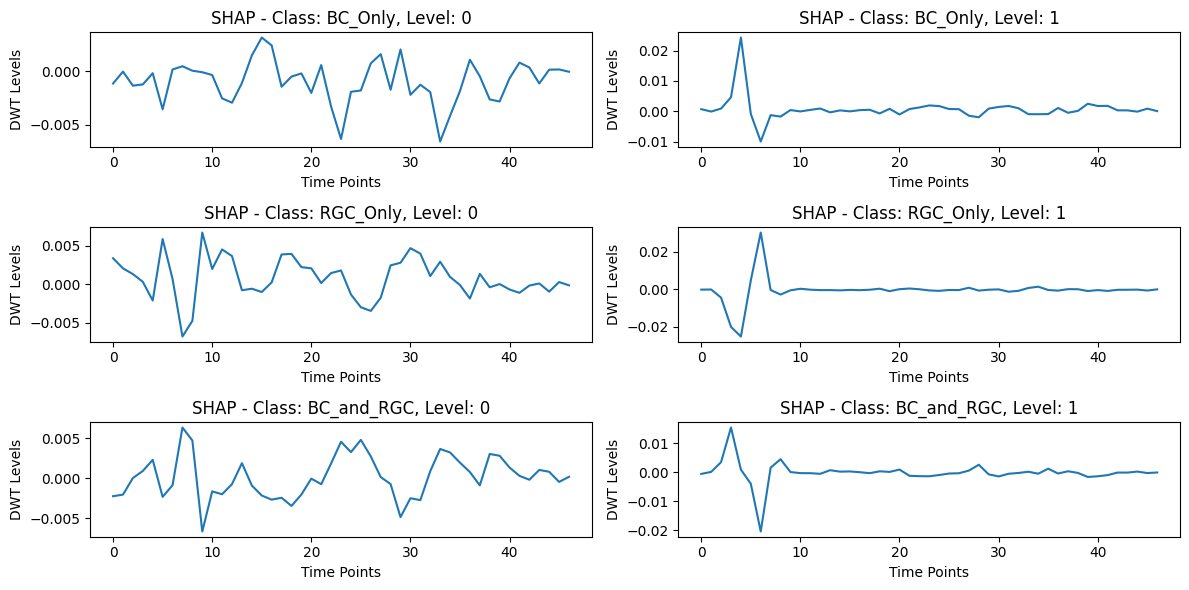

[[11  6  1]
 [ 4 13  1]
 [ 1  1 16]]


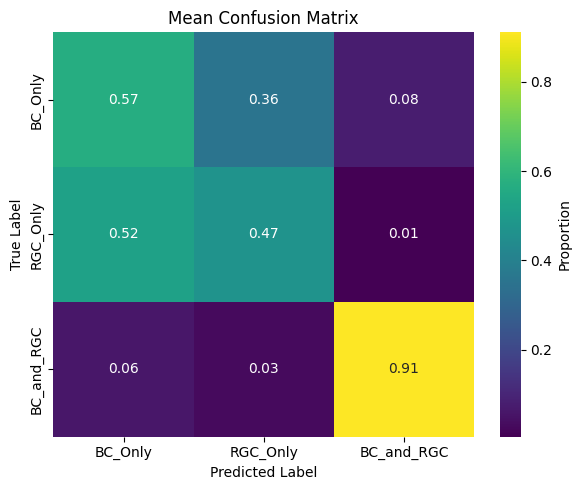

In [8]:
average_results = {}
results = []
mean_shap_values = []
all_conf_matrices = []
for experiments in range(10):
    print(f"--- Experiment {experiments + 1} ---")
    no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
    sampled_BC_train = np.random.choice(prima_files_BC_only, no_files, replace=False)
    sampled_RGC_train = np.random.choice(prima_files_RGC_only, no_files, replace=False)
    sampled_BC_and_RGC_train = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)

    no_files_test = min(len(mp20_files_BC_only), len(mp20_files_RGC_only), len(mp20_files_BC_and_RGC))
    BC_test = np.random.choice(mp20_files_BC_only, no_files_test, replace=False)
    RGC_test = np.random.choice(mp20_files_RGC_only, no_files_test, replace=False)
    BC_and_RGC_test = np.random.choice(mp20_files_BC_and_RGC, no_files_test, replace=False)

    # BC_test = mp20_files_BC_only
    # RGC_test = mp20_files_RGC_only
    # BC_and_RGC_test = mp20_files_BC_and_RGC

    X_train, y_train = [], []
    X_test, y_test = [], []
    TMAX = 150
    LEVEL = 4
    WAVELET = 'db6' # ''db4', db6','coif3','sym5','bior4.4'
    for file in sampled_BC_train:
        _, signal = process_file(file,  t_max=TMAX)
        X_train.append(extract_dwt_features(signal, wavelet=WAVELET, level=LEVEL))
        y_train.append("BC_Only")
    for file in sampled_RGC_train:
        _, signal = process_file(file, t_max=TMAX)
        X_train.append(extract_dwt_features(signal, wavelet=WAVELET, level=LEVEL))
        y_train.append("RGC_Only")
    for file in sampled_BC_and_RGC_train:
        _, signal = process_file(file, t_max=TMAX)
        X_train.append(extract_dwt_features(signal, wavelet=WAVELET, level=LEVEL))
        y_train.append("BC_and_RGC")
    for file in BC_test:
        _, signal = process_file(file, t_max=TMAX)
        X_test.append(extract_dwt_features(signal, wavelet=WAVELET, level=LEVEL))
        y_test.append("BC_Only")
    for file in RGC_test:
        _, signal = process_file(file, t_max=TMAX)
        X_test.append(extract_dwt_features(signal, wavelet=WAVELET, level=LEVEL))
        y_test.append("RGC_Only")
    for file in BC_and_RGC_test:
        _, signal = process_file(file, t_max=TMAX)
        X_test.append(extract_dwt_features(signal, wavelet=WAVELET, level=LEVEL))
        y_test.append("BC_and_RGC")
    X_train = np.stack(X_train, axis=0)                     # (n_samples, n_levels, n_points)
    X_train = np.transpose(X_train, (0, 2, 1)).astype('float32')  # (n_samples, n_points, n_levels)
    X_test = np.stack(X_test, axis=0)                     # (n_samples, n_levels, n_points)
    X_test = np.transpose(X_test, (0, 2, 1)).astype('float32')  # (n_samples, n_points, n_levels)

    n_train = len(X_train)
    batch_size = max(4, min(32, n_train // 12))
    epochs = 50
    print(f"Training samples: {n_train}, batch size: {batch_size}, epochs: {epochs}, n_BC_train: {len(sampled_BC_train)}, n_RGC_train: {len(sampled_RGC_train)}, n_BC_and_RGC_train: {len(sampled_BC_and_RGC_train)}")
    print(f"Testing samples: {len(X_test)}, n_BC_test: {len(BC_test)}, n_RGC_test: {len(RGC_test)}, n_BC_and_RGC_test: {len(BC_and_RGC_test)}")
    clf = Multichannel_1DCNN()
    y_true, y_pred, shap_values = clf.fit_traintest(epochs=epochs, batch_size=batch_size, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


    print("SHAP values shape:", [sv.shape for sv in shap_values])
    # average over folds
    shap_values = np.mean(shap_values, axis=0) # dimension (200, 4, 3) = (n_points, n_levels, n_classes)
    print("Averaged SHAP values shape:", shap_values.shape) 
    mean_shap_values.append(shap_values)

    plt.figure(figsize=(12, 6))
    class_names = ["BC_Only", "RGC_Only", "BC_and_RGC"]
    for i, class_name in enumerate(class_names):
        for j in range(shap_values.shape[1]):
            plt.subplot(len(class_names), shap_values.shape[1], i * shap_values.shape[1] + j + 1)
            plt.title(f"SHAP - Class: {class_name}, Level: {j}")
            plt.plot(shap_values[:, :, i][:, j])
            plt.xlabel("Time Points")
            plt.ylabel("DWT Levels")
    plt.tight_layout()
    plt.show()

    unique_labels = np.unique(y_true)
    metrics = clf.evaluate(y_true, y_pred)

    results.append({
            "Accuracy": metrics["accuracy"],
            "BalancedAcc": metrics["balanced_accuracy"],
            "F1": metrics["f1_score"],
            "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
            "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
            "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
        })
    all_conf_matrices.append(
        confusion_matrix(
            y_true, y_pred, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
        )
    )

accs = [r["Accuracy"] for r in results]
balanced_accs = [r["BalancedAcc"] for r in results]
f1s = [r["F1"] for r in results]
bc_accs = [float(r["Acc BC_Only"]) for r in results]
rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

average_results = {
    "Accuracy_mean": np.mean(accs),
    "Accuracy_std": np.std(accs),
    "BalancedAcc_mean": np.mean(balanced_accs),
    "BalancedAcc_std": np.std(balanced_accs),
    "F1_mean": np.mean(f1s),
    "F1_std": np.std(f1s),

    # per-class accuracies (recall)
    "Acc_BC_Only_mean": np.mean(bc_accs),
    "Acc_BC_Only_std": np.std(bc_accs),
    "Acc_RGC_Only_mean": np.mean(rgc_accs),
    "Acc_RGC_Only_std": np.std(rgc_accs),
    "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
    "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
}
mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

labels = ["BC_Only", "RGC_Only", "BC_and_RGC"] 
plt.figure(figsize=(6,5)) 
sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'}) 
plt.title(f"Mean Confusion Matrix") 
plt.xlabel("Predicted Label") 
plt.ylabel("True Label") 
plt.tight_layout()
plt.show()

In [9]:
# get average results
print("Average Results over 10 experiments:")
for k, v in average_results.items():
    print(f"{k}: {v:.4f}")

Average Results over 10 experiments:
Accuracy_mean: 0.6500
Accuracy_std: 0.0479
BalancedAcc_mean: 0.6500
BalancedAcc_std: 0.0479
F1_mean: 0.6485
F1_std: 0.0471
Acc_BC_Only_mean: 0.5667
Acc_BC_Only_std: 0.0816
Acc_RGC_Only_mean: 0.4722
Acc_RGC_Only_std: 0.1061
Acc_BC_and_RGC_mean: 0.9111
Acc_BC_and_RGC_std: 0.0509


In [10]:
mean_signals_prima = {}
_, avg_signal_prima_BC = compute_average_signal(prima_files_BC_only, t_min=0, t_max=200)
_, avg_signal_prima_RGC = compute_average_signal(prima_files_RGC_only, t_min=0, t_max=200)
_, avg_signal_prima_BC_RGC = compute_average_signal(prima_files_BC_and_RGC, t_min=0, t_max=200)
mean_signals_prima["BC_Only"] = avg_signal_prima_BC
mean_signals_prima["RGC_Only"] = avg_signal_prima_RGC
mean_signals_prima["BC_and_RGC"] = avg_signal_prima_BC_RGC

mean_signals_mp20 = {}
_, avg_signal_mp20_BC = compute_average_signal(mp20_files_BC_only, t_min=0, t_max=200)
_, avg_signal_mp20_RGC = compute_average_signal(mp20_files_RGC_only, t_min=0, t_max=200)
_, avg_signal_mp20_BC_RGC = compute_average_signal(mp20_files_BC_and_RGC, t_min=0, t_max=200)
mean_signals_mp20["BC_Only"] = avg_signal_mp20_BC
mean_signals_mp20["RGC_Only"] = avg_signal_mp20_RGC
mean_signals_mp20["BC_and_RGC"] = avg_signal_mp20_BC_RGC

mean_dwt_features_prima = {} 
mean_dwt_features_prima["BC_Only"] = extract_dwt_features(avg_signal_prima_BC, wavelet='db4', level=4) 
mean_dwt_features_prima["RGC_Only"] = extract_dwt_features(avg_signal_prima_RGC, wavelet='db4', level=4) 
mean_dwt_features_prima["BC_and_RGC"] = extract_dwt_features(avg_signal_prima_BC_RGC, wavelet='db4', level=4) 

mean_dwt_features_mp20 = {}
mean_dwt_features_mp20["BC_Only"] = extract_dwt_features(avg_signal_mp20_BC, wavelet='db4', level=4)
mean_dwt_features_mp20["RGC_Only"] = extract_dwt_features(avg_signal_mp20_RGC, wavelet='db4', level=4)
mean_dwt_features_mp20["BC_and_RGC"] = extract_dwt_features(avg_signal_mp20_BC_RGC, wavelet='db4', level=4)

Global mean SHAP shape: (47, 2, 3)
SHAP thresholds per class at 98 percentile: [0.00806053 0.01163893 0.00670621]


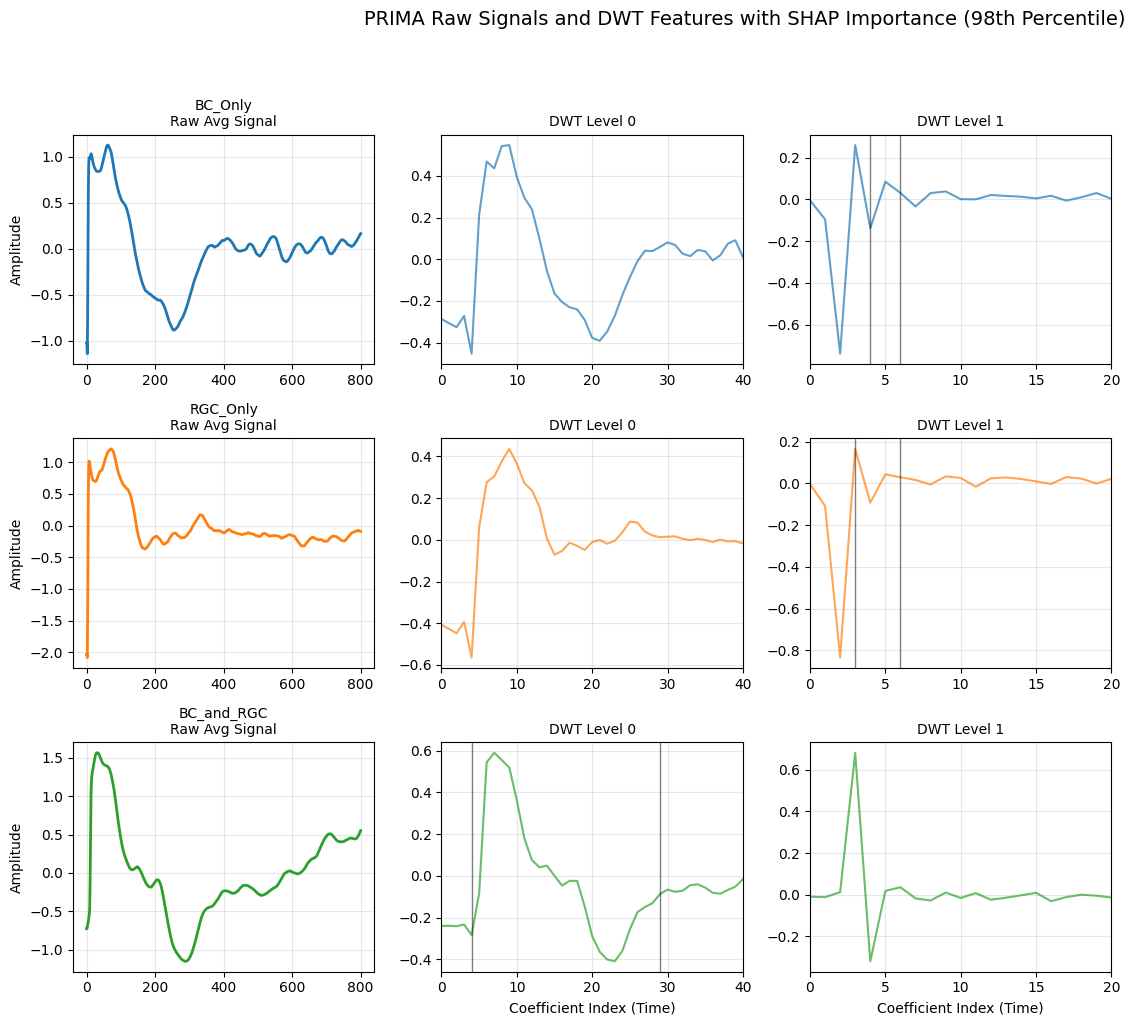

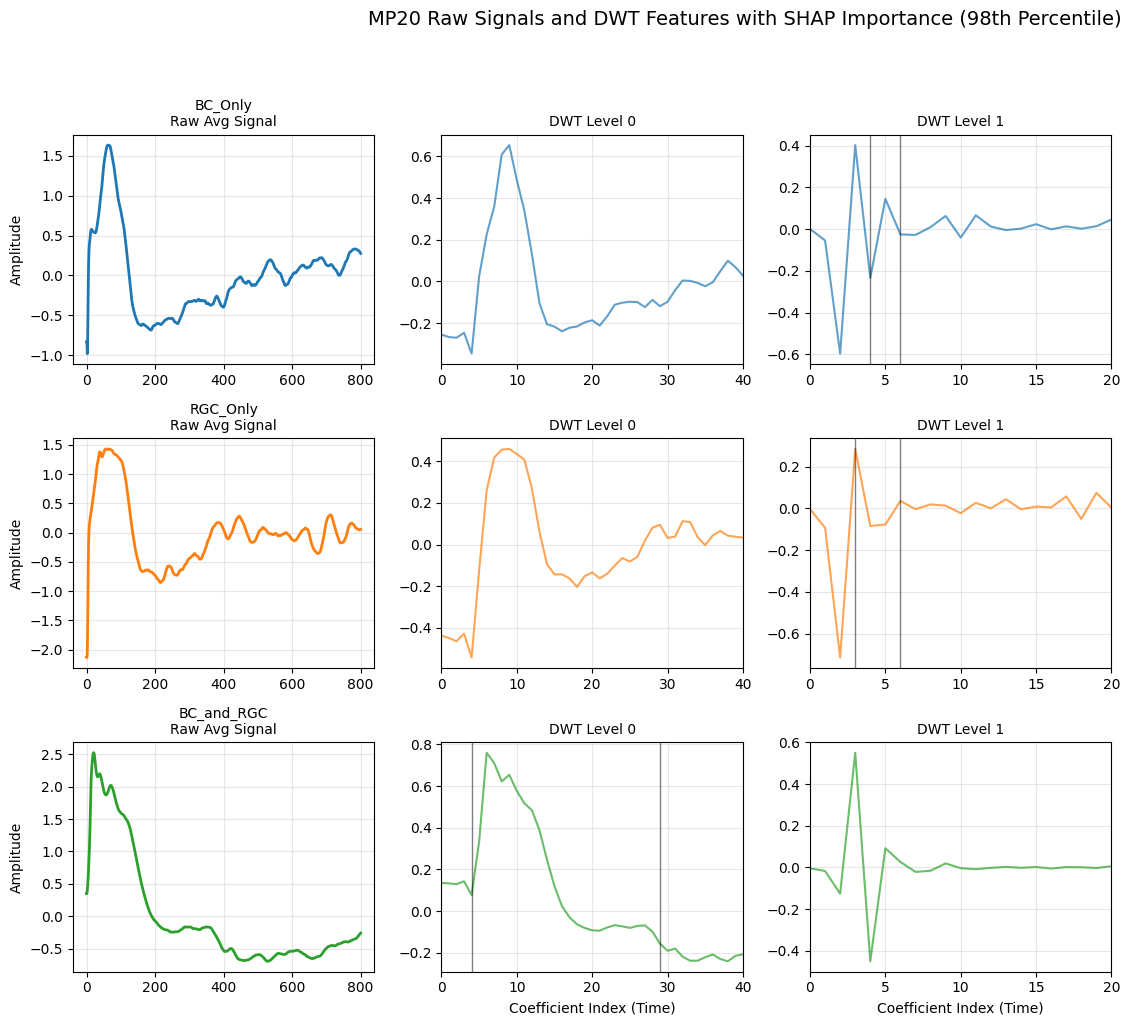

In [11]:
N_LEVELS = 3
ABS_SHAP_THRESHOLD_PERCENTILE = 98
# Average SHAP values across all experiments 
mean_shap_values_global = np.mean(np.stack(mean_shap_values, axis=0), axis=0) # shape (n_points, n_levels, n_classes) 
print("Global mean SHAP shape:", mean_shap_values_global.shape) 
# find 98th percentile threshold for each class
shap_thresholds = np.percentile(np.abs(mean_shap_values_global), ABS_SHAP_THRESHOLD_PERCENTILE, axis=(0, 1))
print("SHAP thresholds per class at", ABS_SHAP_THRESHOLD_PERCENTILE, "percentile:", shap_thresholds)

plot_mean_signals_and_dwt(
    mean_signals_prima, 
    mean_dwt_features_prima, 
    mean_shap_values_global, 
    shap_thresholds, 
    dataset_name="PRIMA", 
    N_LEVELS=N_LEVELS, 
    ABS_SHAP_THRESHOLD_PERCENTILE=ABS_SHAP_THRESHOLD_PERCENTILE
)

plot_mean_signals_and_dwt(
    mean_signals_mp20, 
    mean_dwt_features_mp20, 
    mean_shap_values_global, 
    shap_thresholds, 
    dataset_name="MP20", 
    N_LEVELS=N_LEVELS, 
    ABS_SHAP_THRESHOLD_PERCENTILE=ABS_SHAP_THRESHOLD_PERCENTILE
)